# Presentation of new pyALF features

**1.** Import `Simulation` class from the `py_alf` python module, which provides the interface with ALF:

In [1]:
# Activate matplotlib Jupyter widgets
%matplotlib widget

In [2]:
import numpy as np

from py_alf import ALF_source, Simulation              # Interface with ALF

In [3]:
alf_src = ALF_source()

**2.** Create an instance of `Simulation`, setting parameters as desired:

**New:** Proper support for Parallel Tempering

In [4]:
sim = Simulation(
    alf_src,
    "Hubbard",
    [{
        'L1': 4,
        'L2': 4,
        "Nsweep": 1,
        "Nbin": 1000,
        "Lattice_type": "Square",
        "Ham_U": U,
        "mpi_per_parameter_set": 1
    } for U in [1, 2, 3, 4]
    ],
    n_mpi=4,
    machine='intel'
)

**3.** Compile ALF, downloading it first from the [ALF repository](https://git.physik.uni-wuerzburg.de/ALF/ALF/-/tree/master/) if not found locally. This may take a few minutes:

In [7]:
sim.compile()

Compiling ALF... 
Cleaning up Prog/
Cleaning up Libraries/
Cleaning up Analysis/
Compiling Libraries


ar: creating modules_90.a
ar: creating libqrref.a
ana_mod.F90(1212): warning #5268: Extension to standard: The text exceeds right hand column allowed on the line.
            Write(error_unit,*) 'Evaluating the mutual information between A and B requires the entanglement entropies of A, B and the union of A and B, i.e. Nobs=4 (3 + 1 for the phase)'
-------------------------------------------------------------------------------------------------------------------------------------^


Compiling Analysis


ifort: command line remark #10412: option '-mkl' is deprecated and will be removed in a future release. Please use the replacement option '-qmkl'
ifort: command line remark #10412: option '-mkl' is deprecated and will be removed in a future release. Please use the replacement option '-qmkl'
ifort: command line remark #10412: option '-mkl' is deprecated and will be removed in a future release. Please use the replacement option '-qmkl'
Max_SAC.F90(164): warning #5268: Extension to standard: The text exceeds right hand column allowed on the line.
       If (  nbin_qmc < 2*Ntau .and. N_cov == 1  )   Write(50,*) 'You do not seem to have enough bins for a reliable estimate of the covariance '
-------------------------------------------------------------------------------------------------------------------------------------^
ifort: command line remark #10412: option '-mkl' is deprecated and will be removed in a future release. Please use the replacement option '-qmkl'
ifort: command line rem

Compiling Program
Parsing Hamiltonian parameters
filename: Hamiltonians/Hamiltonian_Kondo_smod.F90
filename: Hamiltonians/Hamiltonian_Hubbard_smod.F90
filename: Hamiltonians/Hamiltonian_Hubbard_Plain_Vanilla_smod.F90
filename: Hamiltonians/Hamiltonian_tV_smod.F90
filename: Hamiltonians/Hamiltonian_LRC_smod.F90
filename: Hamiltonians/Hamiltonian_Z2_Matter_smod.F90
Compiling program modules


Operator_mod.F90(143): warning #5268: Extension to standard: The text exceeds right hand column allowed on the line.
!> * On exit:  phase of  \f$ W(C)  =   \left[ \left( \prod_{n,\tau,f}  \exp \left[ g_f(n) \alpha_f(n) \phi(\sigma(n,\tau)) \right] \right) \det(M_f(C))\right]^{N_{SUN}} \prod_{n,\tau }\gamma(\sigma(n,\tau)) \f$
------------------------------------------------------------------------------------------------------------------------------------^
Predefined_Obs_mod.F90(347): warning #5268: Extension to standard: The text exceeds right hand column allowed on the line.
!>  Returns:  \frac{2N}{N^2-1}\sum_{a=1}{N^2 - 1 }  <c^{dag}_i(tau) T^a c_i (tau)  c^{dag}_j T^a  c_j>  where  T^a are th generators of SU(N)
------------------------------------------------------------------------------------------------------------------------------------^
./Cotunneling_dimer_obs.F90(226): warning #5268: Extension to standard: The text exceeds right hand column allowed on the line.
           

Link program


ifort: command line remark #10412: option '-mkl' is deprecated and will be removed in a future release. Please use the replacement option '-qmkl'


Done.


**4.** Perform the simulation as specified in `sim`:

In [8]:
sim.run()

Prepare directory "/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1" for Monte Carlo run.
Prepare directory "/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_0" for Monte Carlo run.
Resuming previous run.
Prepare directory "/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_1" for Monte Carlo run.
Resuming previous run.
Prepare directory "/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_2" for Monte Carlo run.
Resuming previous run.
Prepare directory "/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_3" for Monte Carlo run.
Resuming previous run.
Run /home/jonas/Programs/ALF/Prog/ALF.out
 ALF Copyright (C) 2016 - 2021 The ALF project contributors
 This Program comes with ABSOLUTELY NO WARRANTY; for details see license.GPL
 This is free software, and you are welcome to redistribute it under certain condition

**New:** Derived observables

In [5]:
custom_obs = {}

In [6]:
def obs_squared(obs, sign, N_obs):
    return obs**2 / sign

# Energy squared
custom_obs['E_squared']= {
    'needs': ['Ener_scal'],
    'function': obs_squared,
    'kwargs': {}
}

In [7]:
def E_pot_kin(E_pot_obs, E_pot_sign, E_pot_N_obs, E_kin_obs, E_kin_sign, E_kin_N_obs):
    return E_pot_obs/E_kin_obs / (E_pot_sign/E_kin_sign)

# Potential Energy / Kinetic Energy
custom_obs['E_pot_kin']= {
    'needs': ['Pot_scal', 'Kin_scal'],
    'function': E_pot_kin,
    'kwargs': {}
}

In [8]:
def R_k(obs, back, sign, N_orb, N_tau, dtau, latt,
        ks=[(0., 0.)], mat=None, NNs=[(1, 0), (0, 1), (-1, 0), (0, -1)]):
    """RG-invariant quantity derived from a correlatian function.
    
    obs.shape = (N_orb, N_orb, N_tau, latt.N)
    back.shape = (N_orb,)
    """
    if mat is None:
        mat = np.identity(N_orb)
    out = 0
    for k in ks:
        n = latt.k_to_n(k)

        J1 = (obs[..., n].sum(axis=-1) * mat).sum()
        J2 = 0
        for NN in NNs:
            i = latt.nnlistk[n, NN[0], NN[1]]
            J2 += (obs[..., i].sum(axis=-1) * mat).sum() / len(NNs)
        out += (1 - J2/J1)

    return out / len(ks)

# RG-invariant quantity for ferromagnetic order
custom_obs['R_Ferro']= {
    'needs': ['SpinZ_eq'],
    'function': R_k,
    'kwargs': {'ks': [[0., 0.]]}
}

# RG-invariant quantity for antiferromagnetic order
custom_obs['R_AFM']= {
    'needs': ['SpinZ_eq'],
    'function': R_k,
    'kwargs': {'ks': [[np.pi, np.pi]]}
}

**New:** Check warmup and autocorrelation

In [9]:
sim.check_warmup(
    ['Ener_scal', 'Kin_scal', 'Pot_scal', 'E_pot_kin', 'R_Ferro', 'R_AFM'],
    custom_obs=custom_obs, gui='ipy'
)

In [10]:
sim.check_rebin(
    ['Ener_scal', 'Kin_scal', 'Pot_scal', 'E_pot_kin', 'R_Ferro', 'R_AFM'],
    custom_obs=custom_obs, gui='ipy'
)

**New:** Lattice symmetries in analysis

In [11]:
# Define list of transformations (Lattice, i) -> new_i
# Default analysis will average over all listed elements
def sym_c4_0(latt, i): return i
def sym_c4_1(latt, i): return latt.rotate(i, np.pi*0.5)
def sym_c4_2(latt, i): return latt.rotate(i, np.pi)
def sym_c4_3(latt, i): return latt.rotate(i, np.pi*1.5)

sym_c4 = [sym_c4_0, sym_c4_1, sym_c4_2, sym_c4_3]

**5.** Perform anaylsis:

In [12]:
sim.analysis(symmetry=sym_c4, custom_obs=custom_obs)

### Analyzing /home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_0 ###
/home/jonas/Programs/pyALF/Notebooks
Custom observables:
custom E_squared ['Ener_scal']
custom E_pot_kin ['Pot_scal', 'Kin_scal']
custom R_Ferro ['SpinZ_eq']
custom R_AFM ['SpinZ_eq']
Scalar observables:
Acc_Temp_scal
Ener_scal
Kin_scal
Part_scal
Pot_scal


/home/jonas/Programs/pyALF/py_alf/ana.py:582: RuntimeWarning: invalid value encountered in true_divide
  J = J_obs[:, n] / J_sign


Histogram observables:
Equal time observables:
Den_eq
Green_eq
SpinT_eq
SpinXY_eq
SpinZ_eq
Time displaced observables:
Den_tau
Green_tau
SpinT_tau
SpinXY_tau
SpinZ_tau
### Analyzing /home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_1 ###
/home/jonas/Programs/pyALF/Notebooks
Custom observables:
custom E_squared ['Ener_scal']
custom E_pot_kin ['Pot_scal', 'Kin_scal']
custom R_Ferro ['SpinZ_eq']
custom R_AFM ['SpinZ_eq']
Scalar observables:
Acc_Temp_scal
Ener_scal
Kin_scal
Part_scal
Pot_scal
Histogram observables:
Equal time observables:
Den_eq
Green_eq
SpinT_eq
SpinXY_eq
SpinZ_eq
Time displaced observables:
Den_tau
Green_tau
SpinT_tau
SpinXY_tau
SpinZ_tau
### Analyzing /home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_2 ###
/home/jonas/Programs/pyALF/Notebooks
Custom observables:
custom E_squared ['Ener_scal']
custom E_pot_kin ['Pot_scal', 'Kin_scal']
custom R_Ferro ['SpinZ_eq']
custom R_AFM ['SpinZ_eq']
Scalar obs

**6.** Read analysis results:

In [13]:
obs = sim.get_obs()

/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_0
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_1
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_2
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_3


In [14]:
obs

,continuous,ham_chem,ham_t,ham_t2,ham_tperp,ham_u,ham_u2,mz,l1,l2,...,SpinXY_tauK,SpinXY_tauK_err,SpinXY_tauR,SpinXY_tauR_err,SpinXY_tau_lattice,SpinZ_tauK,SpinZ_tauK_err,SpinZ_tauR,SpinZ_tauR_err,SpinZ_tau_lattice
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_0,0,0.0,1.0,1.0,1.0,1.0,4.0,1,4,4,...,"[[0.5757160385946102, 0.40401888111533135, 0.5...","[[0.0005446044164480967, 0.000809042640914045,...","[[0.009848341315475111, -0.08319531022495344, ...","[[0.00010000886007819457, 0.000230045679476702...","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'a1': [1....","[[0.5794453448680349, 0.40334679681423685, 0.5...","[[0.0021580855984054013, 0.0011314248295812815...","[[0.009369489151954407, -0.083162115940077, 0....","[[0.0009652941089291849, 0.0008862884937888805...","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'a1': [1...."
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_1,0,0.0,1.0,1.0,1.0,2.0,4.0,1,4,4,...,"[[0.6296730924655389, 0.420232440939927, 0.629...","[[0.0023128004163593847, 0.002271022114323544,...","[[0.03453755534838083, -0.11162706310685504, 0...","[[0.004251757383808721, 0.0016718510192865628,...","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'a1': [1....","[[0.6349721420135782, 0.420149551123146, 0.634...","[[0.0051367041676087565, 0.0024246447822135974...","[[0.03001447662055974, -0.11100605800234216, 0...","[[0.002500550143171231, 0.002418789895582074, ...","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'a1': [1...."
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_2,0,0.0,1.0,1.0,1.0,3.0,4.0,1,4,4,...,"[[0.6732851192703257, 0.4433700077388736, 0.67...","[[0.0065819174513264776, 0.0053821337659886136...","[[0.0614966008326908, -0.15176648073825152, 0....","[[0.0030914049400888625, 0.003434195079286212,...","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'a1': [1....","[[0.6542326064300708, 0.43171368756209244, 0.6...","[[0.008338320071117095, 0.0047485366919165495,...","[[0.06912949094891366, -0.15871531229074895, 0...","[[0.00600793358453017, 0.00541739449024013, 0....","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'a1': [1...."
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_3,0,0.0,1.0,1.0,1.0,4.0,4.0,1,4,4,...,"[[0.6944204820233051, 0.45177266682346945, 0.6...","[[0.01872898219196942, 0.07335258405356, 0.018...","[[0.10435528272033436, -0.2297786268988588, 0....","[[0.00932064101036812, 0.026987665687073836, 0...","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'a1': [1....","[[0.6352098829552052, 0.4305891107886974, 0.63...","[[0.015337213481308258, 0.008957827949087229, ...","[[0.12670645940256767, -0.23001413175839464, 0...","[[0.011906622768436818, 0.011026898430399664, ...","{'L1': [4.0, 0.0], 'L2': [0.0, 4.0], 'a1': [1...."


which are available for further analyses. For instance, the internal energy of the system (and its error) is accessed by:

In [17]:
obs[['ham_u', 'Ener_scal0', 'Ener_scal0_err', 'Ener_scal_sign', 'E_pot_kin', 'E_pot_kin_err', 'R_Ferro', 'R_AFM']]

,ham_u,Ener_scal0,Ener_scal0_err,Ener_scal_sign,E_pot_kin,E_pot_kin_err,R_Ferro,R_AFM
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_0,1.0,-20.377465,0.003788,1.0,-0.144711,0.000064,-0.525206,0.341776
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_1,2.0,-17.418278,0.010179,1.0,-0.251871,0.000321,-0.475288,0.494956
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_2,3.0,-15.053381,0.017179,1.0,-0.326591,0.000769,-0.628601,0.629519
/home/jonas/Programs/pyALF/Notebooks/ALF_data/temper_Hubbard_L1=4_L2=4_Square_U=1/Temp_3,4.0,-13.186436,0.025273,1.0,-0.374299,0.001097,-1.381611,0.734128


<ErrorbarContainer object of 3 artists>

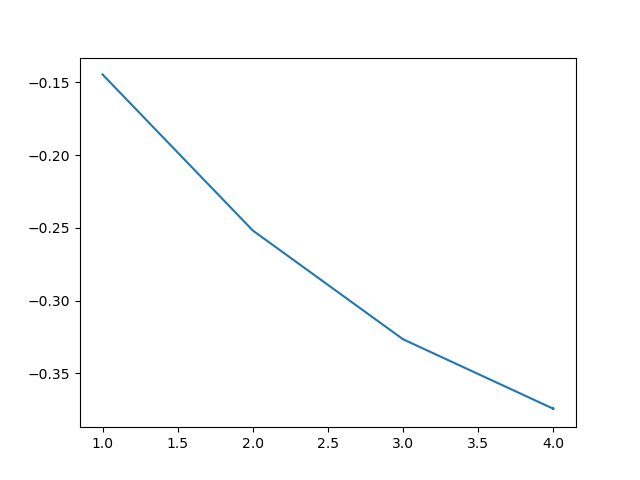

In [16]:
import matplotlib.pyplot as plt
plt.figure()
plt.errorbar(obs.ham_u, obs.E_pot_kin, obs.E_pot_kin_err)

**New:** 2dplot on bravais lattice

In [18]:
from py_alf import Lattice

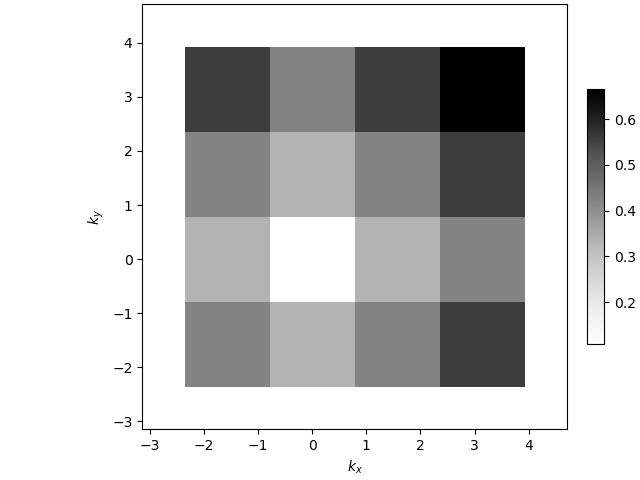

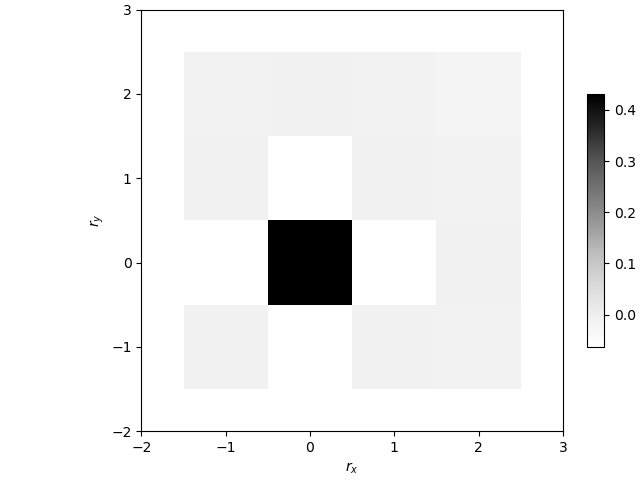

In [19]:
item = obs.iloc[0]

latt = Lattice(item.Den_eq_lattice)

latt.plot_k(item.Den_eqK[0, 0])
latt.plot_r(item.Den_eqR[0, 0])